# LAPD lab - Machine learning project

This notebook contains the exploration of several cloud detector and explain how to add it to the images as a new dimension in order to feed a model

## Environnement and dataset definition

### Libraries

First, we import all important packages, data, and set the seed (for torch).


In [19]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
import math
import random
import itertools

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils

import cv2

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

### Seed definition

In an attempt for reproducibility, we define a torch seed for random processes.

In [20]:
# Set fixed random number seed
torch.manual_seed(3174)

### Mounting the drive
You may need to adjust the path according to your needs.

In [21]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
#path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
#path = 'drive/MyDrive/master/CSS 433/data' #Jade
path = 'drive/MyDrive/data' #Jade ordi 2
#path = 'drive/MyDrive/CSS 433/data' #Alison

for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy


### Creation of the Dataset

This class allows us to load the dataset and access each element individually.

#### GHIDataset 2

This dataset allows to retrieve multiple indices at once, hence allowing to load consecutive samples.

In [22]:
class GHIDataset2(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_images=None, transform_label=None, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required
        if normalise_meteo:
          self.day = torch.tensor(preprocessing.normalize([day_])[0])
          self.month = torch.tensor(preprocessing.normalize([month_])[0])
          self.year = torch.tensor(preprocessing.normalize([year_])[0])
          self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
          self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
          self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
          self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
          self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])
        else:
          self.day = torch.tensor(day_)
          self.month = torch.tensor(month_)
          self.year = torch.tensor(year_)
          self.hour = torch.tensor(hour_)
          self.minute = torch.tensor(minute_)
          self.air_temp = torch.from_numpy(df['Air_temp'].values)
          self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
          self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir),dim=1).to(torch.float32)
        # Apply the transforms
        if self.transform_images:
          image0_transformed = []
          image1_transformed = []
          for image in image0:
            image0_transformed.append(self.transform_images(image))
          for image in image1:
            image1_transformed.append(self.transform_images(image))

        if self.transform_label:
            labels = self.transform_label(labels)

        data = (torch.stack(image0_transformed),torch.stack(image1_transformed),meteo_data,labels)

        return data

Below we load the dataset and transfom the images.

#### Dataset Creation

In [23]:
# Set the desired size of the image
img_size = 100

# The following line creates a transform which converts the np.array to a PIL Image.
# It then resizes the image to img_size x img_size and converts the image to a tensor

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Generate the dataset containing all the samples
#ghi_dataset = GHIDataset(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)
ghi_dataset = GHIDataset2(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)

# Cloud detector

## Function

We developped several cloud detectors.
We know that clouds are crucial to determine the GHI. The neural network should already detect clouds but we can try to help him by detecting the clouds ourselves and add it as a layer of the image

1. Cloud segmentor
  use the level of gray in the image to detect cloud. It can also be ajusted to take out region where there is too much yellow light (sun, artefact).
2. Blue cloud detector
  use the level of blue to extract the position of the cloud.
3. cloud detector
  The function use a totally different approach, based on edge detection.

In [39]:
def cloud_segmentor(original, position, light = False, binary = True):
  image = original.clone()
  image = image.permute(1,2,0).numpy()

  # crop the bottom of the image
  if position ==1 :
    image[-40:, :] = 0
  elif position == 2:
    image[-55:, :] = 0

  #threshold of grey
  gray_threshold = 80/255
  white_threshold = 5/255
  light_yellow_threshold = 150/255


# Calculate a measure of "grayness" based on RGB values
  grayness_measure = np.abs(image[:, :, 0] - image[:, :, 1]) + np.abs(image[:, :, 0] - image[:, :, 2]) + np.abs(image[:, :, 1] - image[:, :, 2])

# Normalize the grayness measure
  grayness_measure = (grayness_measure - np.min(grayness_measure)) / (np.max(grayness_measure) - np.min(grayness_measure))

# Set pixels to black if they are either blue or gray
  #image[image[:, :, 2] > blue_threshold] = 0
  image[grayness_measure > gray_threshold] = 0
  image[grayness_measure < white_threshold] = 0

  if light :
# Set pixels to 0 that are too light (close to white/light yellow) in the original image
    too_light_pixels = np.all(image > light_yellow_threshold, axis=-1)
    image[too_light_pixels] = 0

  if binary :
# Set pixels to white if they are not black
    image[np.where(image != 0)] = 1

  # Convert the 3-channel image to grayscale
  grayscale_image = np.mean(image, axis=-1)


  return grayscale_image

In [35]:
def cloud_blue_segmentor(original,position): # a version that use blue tone and grey tone
  image = original.clone()
  image = image.permute(1,2,0).numpy()

  # crop the bottom of the image
  if position ==1 :
    image[-40:, :] = 0
  elif position == 2:
    image[-55:, :] = 0

  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  gray_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

  # Apply a threshold to segment the clouds
  th = 160/255
  _, binary_mask = cv2.threshold(gray_image, th, 1, cv2.THRESH_BINARY)
  binary_mask = binary_mask.astype(np.uint8)

# Set pixels to black if corresponding pixel in color_image is blue
  blue_threshold = 240/255  # Adjust this threshold based on your image
  blue_pixels = (image[:, :, 2] > blue_threshold)  # Assuming blue channel is the third channel (0-indexed)
  binary_mask[blue_pixels] = 0


#print(color_image)
# Apply the binary mask to the original image
  clouds_only = cv2.bitwise_and(image, image, mask=binary_mask)
  clouds_only[np.where( clouds_only != 0)] = 1

  return clouds_only

In [36]:
def cloud_detector(original,position): # a version that use edges
  image = original.clone()
  image = image.permute(1,2,0).numpy()

  # crop the bottom of the image
  if position ==1 :
    image[-40:, :] = 0
  elif position == 2:
    image[-55:, :] = 0

    # Convert the image to grayscale
  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # Normalize pixel values to the range [0, 255]
  gray_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

    # Convert the normalized image to np.uint8
  gray_image = gray_image.astype(np.uint8)

    # Use the Canny edge detector to detect edges
  edges = cv2.Canny(gray_image, 50,150)  # Adjust parameters as needed

  # Apply a morphological operation to close small gaps in between edge segments
  kernel = np.ones((5, 5), np.uint8)
  closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Set pixels to white in the edges image
  closed_edges[np.where(closed_edges != 0)] = 1

  return closed_edges

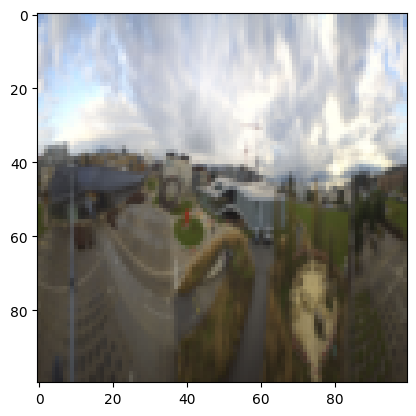

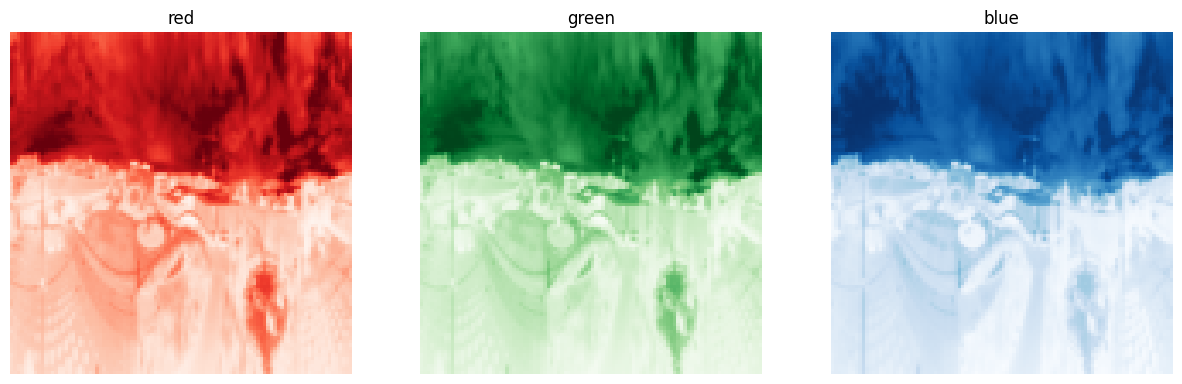

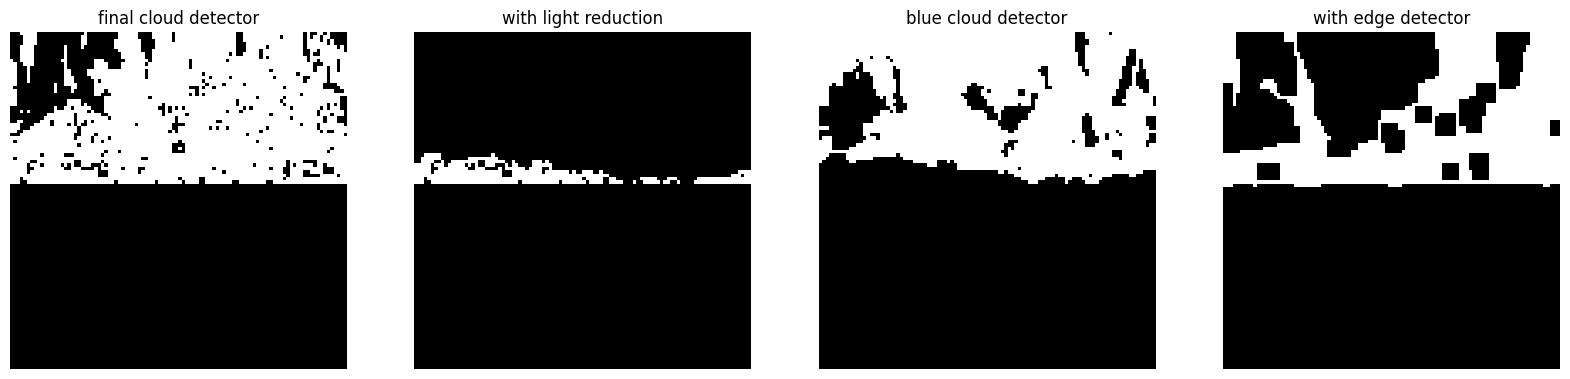

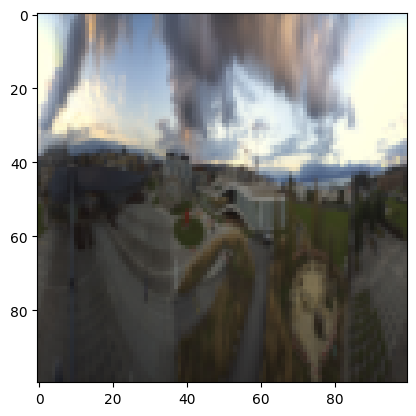

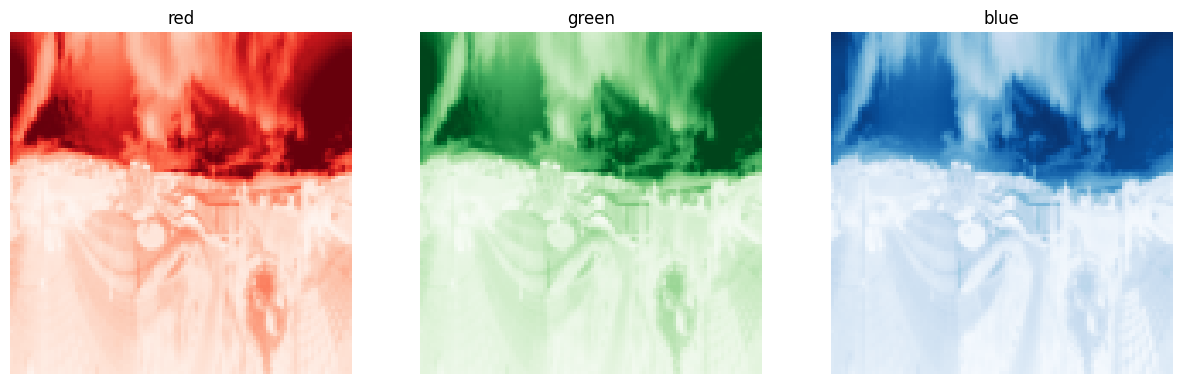

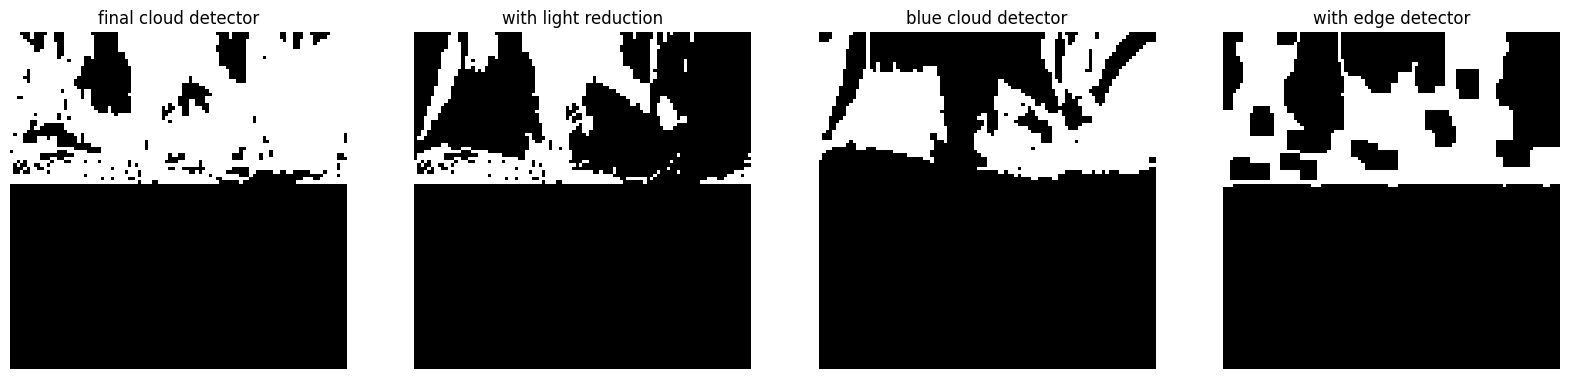

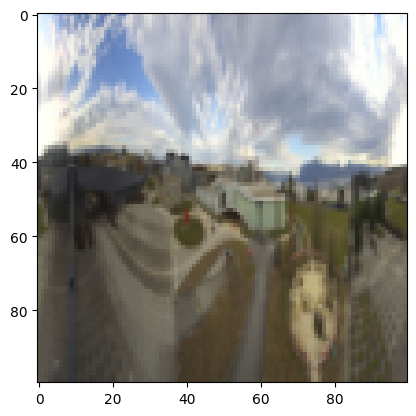

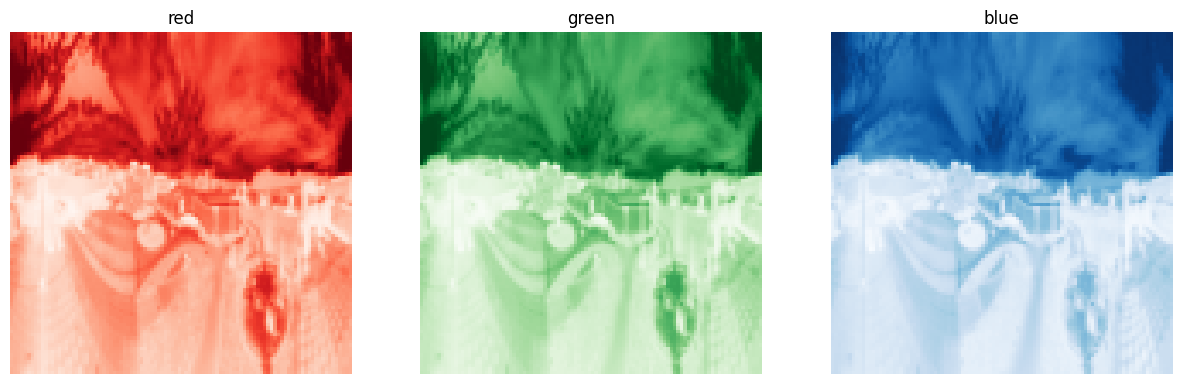

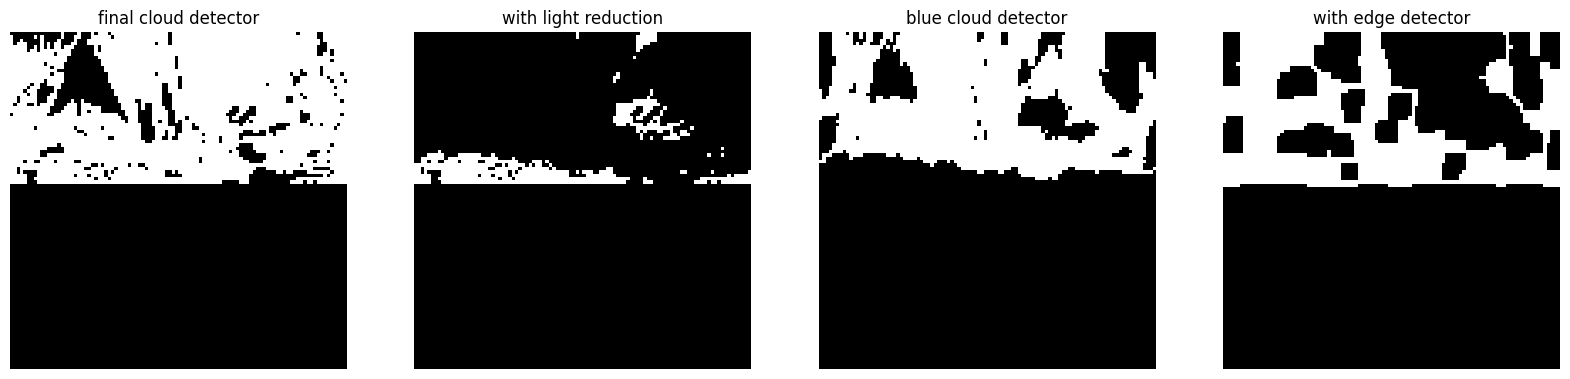

In [46]:
tested = [3,30,2000]

for i in tested :
  image_test = ghi_dataset[[i]][1][0]


  plt.figure()
  plt.imshow(image_test.permute(1,2,0))


  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(image_test.permute(1,2,0)[:, :, 0], cmap='Reds')
  plt.title('red')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(image_test.permute(1,2,0)[:, :, 1], cmap='Greens')
  plt.title('green')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(image_test.permute(1,2,0)[:, :, 2], cmap='Blues')
  plt.title('blue')
  plt.axis('off')

  plt.show()

  t1 = cloud_segmentor(image_test,2,False)
  t2 = cloud_segmentor(image_test,2,True)
  t3 = cloud_blue_segmentor(image_test,2)
  t4 = cloud_detector(image_test,2)


  plt.figure(figsize=(20, 5))

  plt.subplot(1, 4, 1)
  plt.imshow(t1,cmap='gray')
  plt.title('final cloud detector')
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.imshow(t2,cmap='gray')
  plt.title('with light reduction')
  plt.axis('off')


  plt.subplot(1, 4, 3)
  plt.imshow(t3,cmap='gray')
  plt.title('blue cloud detector')
  plt.axis('off')

  plt.subplot(1, 4, 4)
  plt.imshow(t4,cmap='gray')
  plt.title('with edge detector')
  plt.axis('off')

  plt.show()



## Test of the best function

We decided that the cloud segmentor give the best result. We apply it here to a sample of images from the two webcams to assess it efficiency.

If the cloud are well define, the detection is good. The detector is sensible to the sun, fog and artefacts.

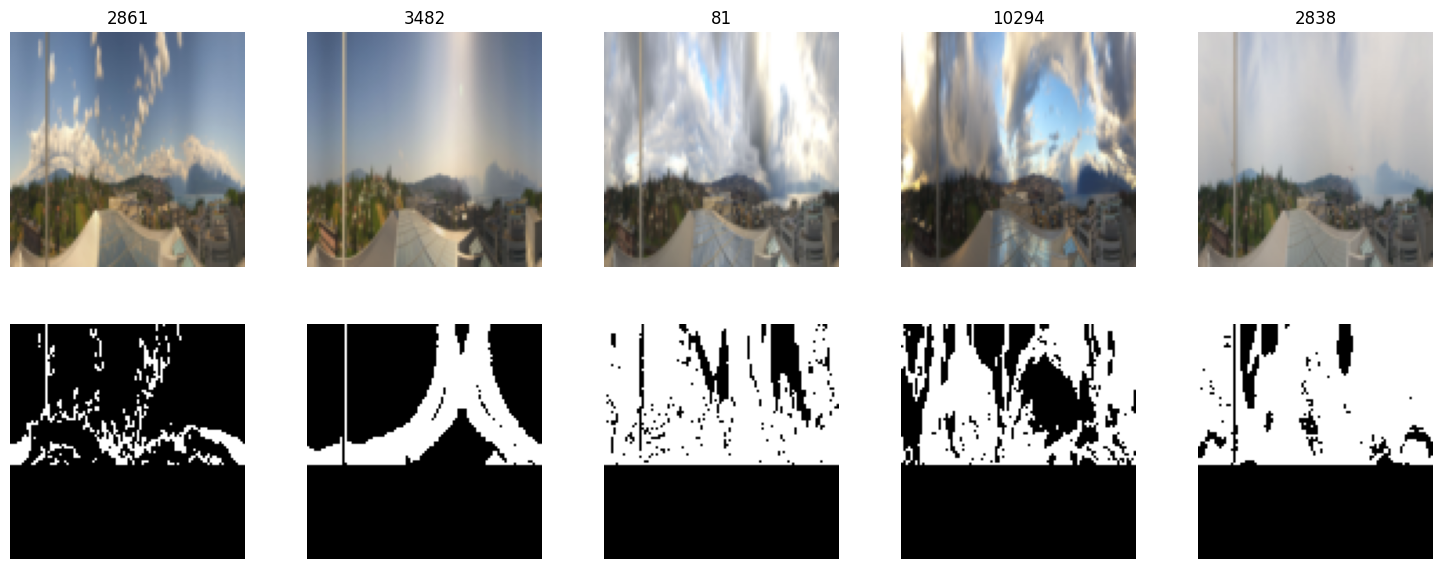

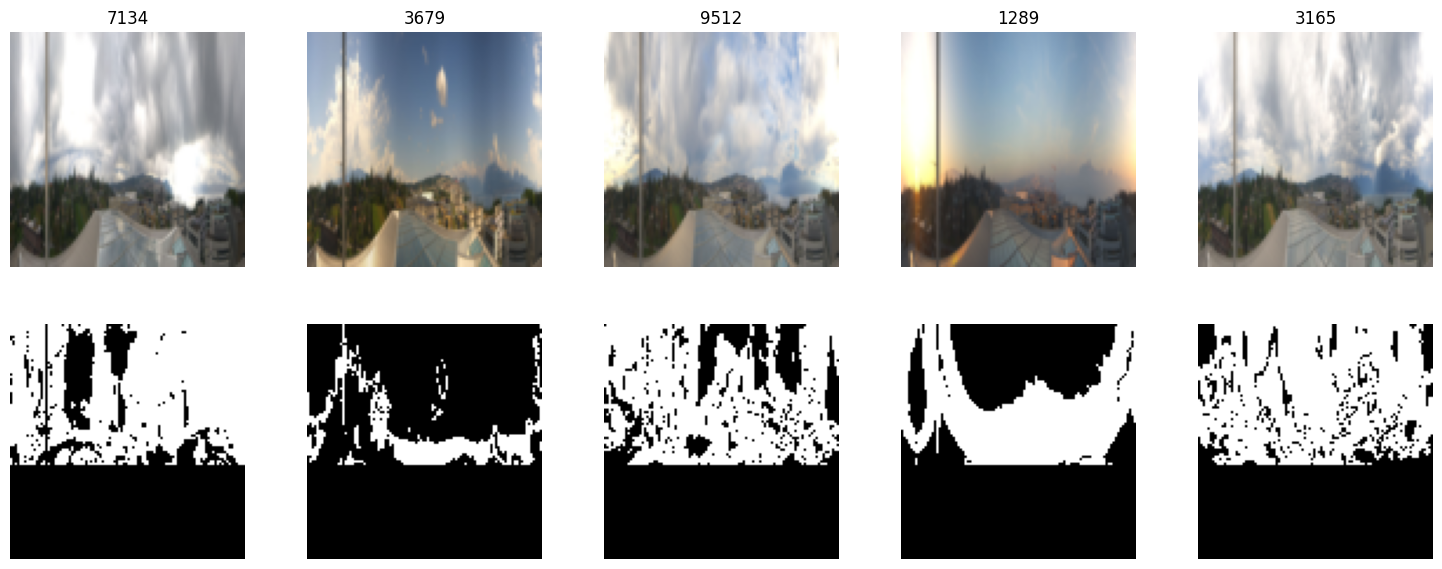

In [47]:
length = len(ghi_dataset)
num_random_indices = 5

np.random.seed(48)

# Generate random indices
random_indices = np.random.choice(length, size=num_random_indices, replace=False)

fig, axs = plt.subplots(2, num_random_indices, figsize=(15, 6))

plt.tight_layout()
for i in range(num_random_indices):
  data = ghi_dataset[[random_indices[i]]][0][0]
  axs[0, i].set_title(str(random_indices[i]))
  axs[0, i].imshow(data.permute(1,2,0))
  axs[0, i].axis('off')
  im2 = cloud_segmentor(data,1)
  axs[1, i].imshow(im2, cmap='gray')
  axs[1, i].axis('off')


np.random.seed(500)

# Generate random indices
random_indices = np.random.choice(length, size=num_random_indices, replace=False)

fig, axs = plt.subplots(2, num_random_indices, figsize=(15, 6))

plt.tight_layout()
for i in range(num_random_indices):
  data = ghi_dataset[[random_indices[i]]][0][0]
  axs[0, i].set_title(str(random_indices[i]))
  axs[0, i].imshow(data.permute(1,2,0))
  axs[0, i].axis('off')
  im2 = cloud_segmentor(data,1)
  axs[1, i].imshow(im2, cmap='gray')
  axs[1, i].axis('off')

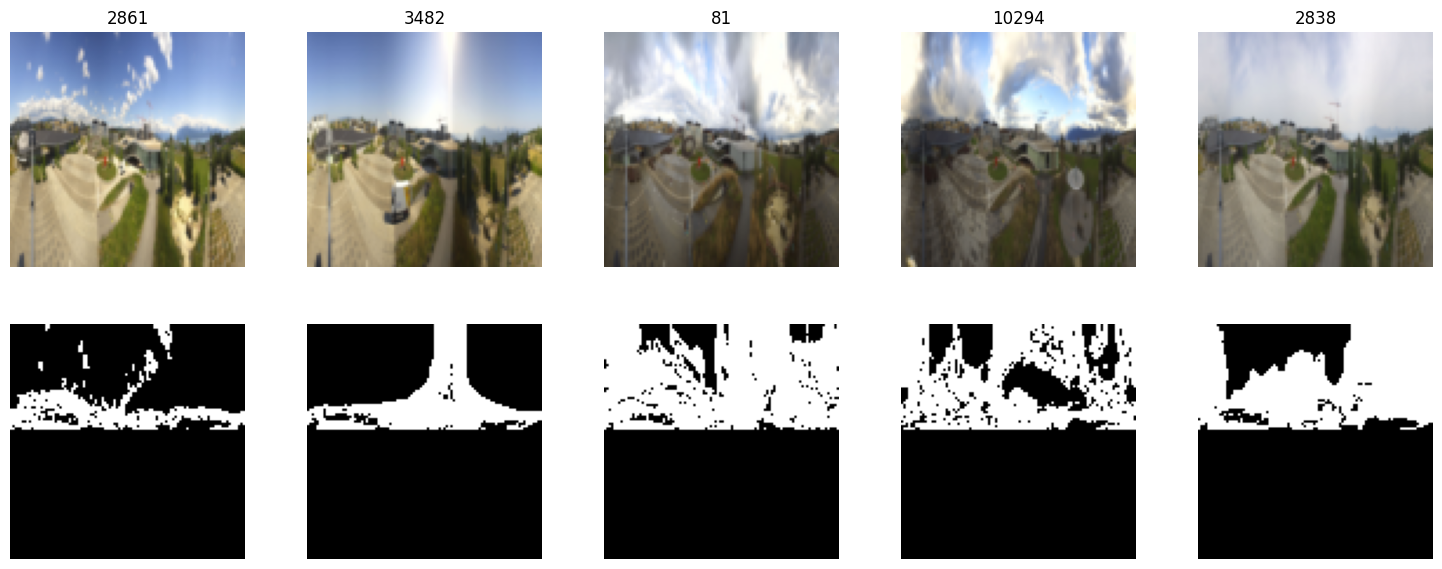

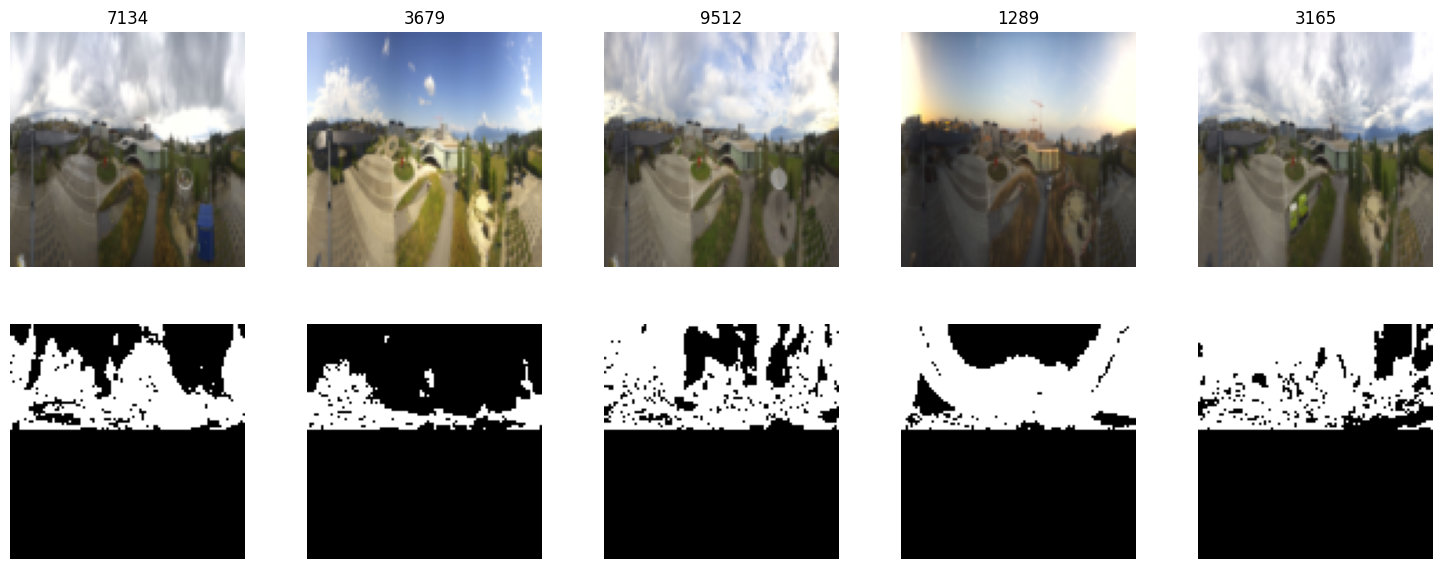

In [48]:
# same verification for the second picture

length = len(ghi_dataset)
num_random_indices = 5

np.random.seed(48)

# Generate random indices
random_indices = np.random.choice(length, size=num_random_indices, replace=False)

fig, axs = plt.subplots(2, num_random_indices, figsize=(15, 6))

plt.tight_layout()
for i in range(num_random_indices):
  data = ghi_dataset[[random_indices[i]]][1][0]
  axs[0, i].set_title(str(random_indices[i]))
  axs[0, i].imshow(data.permute(1,2,0))
  axs[0, i].axis('off')
  im2 = cloud_segmentor(data,2)
  axs[1, i].imshow(im2, cmap='gray')
  axs[1, i].axis('off')


np.random.seed(500)

# Generate random indices
random_indices = np.random.choice(length, size=num_random_indices, replace=False)

fig, axs = plt.subplots(2, num_random_indices, figsize=(15, 6))

plt.tight_layout()
for i in range(num_random_indices):
  data = ghi_dataset[[random_indices[i]]][1][0]
  axs[0, i].set_title(str(random_indices[i]))
  axs[0, i].imshow(data.permute(1,2,0))
  axs[0, i].axis('off')
  im2 = cloud_segmentor(data,2)
  axs[1, i].imshow(im2, cmap='gray')
  axs[1, i].axis('off')

Now that we verified that the cloud detector work, we will add this feature to the images.

## Definition of a new dataset with clouds

This dataset class add the cloud as the 4 dimension of the image.

In [30]:
class GHIDataset3(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_images=None, transform_label=None, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required
        if normalise_meteo:
          self.day = torch.tensor(preprocessing.normalize([day_])[0])
          self.month = torch.tensor(preprocessing.normalize([month_])[0])
          self.year = torch.tensor(preprocessing.normalize([year_])[0])
          self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
          self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
          self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
          self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
          self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])
        else:
          self.day = torch.tensor(day_)
          self.month = torch.tensor(month_)
          self.year = torch.tensor(year_)
          self.hour = torch.tensor(hour_)
          self.minute = torch.tensor(minute_)
          self.air_temp = torch.from_numpy(df['Air_temp'].values)
          self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
          self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir),dim=1).to(torch.float32)
        # Apply the transforms
        if self.transform_images:
          image0_transformed = []
          image1_transformed = []
          for image in image0:
            im1 = self.transform_images(image)
            result_tensor = torch.cat([im1, torch.tensor(cloud_segmentor(im1,1)).unsqueeze(0)], dim=0)
            image0_transformed.append(result_tensor)
          for image in image1:
            im2 = self.transform_images(image)
            result_tensor = torch.cat([im2, torch.tensor(cloud_segmentor(im2,2)).unsqueeze(0)], dim=0)
            image1_transformed.append(result_tensor)
        if self.transform_label:
            labels = self.transform_label(labels)

        data = (torch.stack(image0_transformed),torch.stack(image1_transformed),meteo_data,labels)

        return data

In [31]:
ghi_dataset_final = GHIDataset3(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform,normalise_meteo=True) #definition of the dataset

print("shape of a image : ", str(ghi_dataset_final[[0]][0][0].shape) )

0.4470588 0.0
0.4235294 0.0
shape of a image :  torch.Size([4, 100, 100])
